In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import numpy as np


In [2]:
df = pd.read_csv("1976-2020-senate.csv")

In [3]:
df
df_mod = df[df['stage'] == 'gen']
df_mod = df_mod[df_mod['party_simplified'].isin(['REPUBLICAN', 'DEMOCRAT'])]
grouped = df_mod.groupby(['year', 'party_simplified'])['candidatevotes'].sum().unstack().fillna(0)
grouped['Total'] = grouped.sum(axis=1)
grouped['DEMOCRAT_pct'] = 100 * grouped['DEMOCRAT'] / grouped['Total']
grouped['REPUBLICAN_pct'] = 100 * grouped['REPUBLICAN'] / grouped['Total']

In [4]:
years = grouped.index.values
t = years - years[0]
vote_A = grouped['DEMOCRAT_pct'].values
vote_B = grouped['REPUBLICAN_pct'].values
initial_conditions = [vote_A[0], vote_B[0]]

In [5]:
def lotka_volterra(y, t, alpha, beta, delta, gamma):
    x, y_val = y
    dxdt = alpha * x - beta * x * y_val
    dydt = delta * x * y_val - gamma * y_val
    return [dxdt, dydt]

In [6]:
def modified_lv(y, t, alpha, beta, delta, gamma, K=100):
    x, y_val = y
    dxdt = alpha * x * (1 - x / K) - beta * x * y_val
    dydt = delta * x * y_val - gamma * y_val * (1 - y_val / K)
    return [dxdt, dydt]

In [8]:
def objective(params):
    alpha, beta, delta, gamma = params
    sol = odeint(modified_lv, initial_conditions, t, args=(alpha, beta, delta, gamma))
    x_model, y_model = sol.T
    return np.sum((vote_A - x_model)**2 + (vote_B - y_model)**2)

In [10]:
initial_guess = [1e-5, 1e-5, 1e-5, 1e-5]
bounds = [(0, 1)] * 4
result = minimize(objective, initial_guess, bounds=bounds)
alpha, beta, delta, gamma = result.x
print(f"Fitted parameters: alpha={alpha:.4f}, beta={beta:.4f}, delta={delta:.4f}, gamma={gamma:.4f}")

Fitted parameters: alpha=0.0000, beta=0.0001, delta=0.0001, gamma=0.0000


In [13]:
sol = odeint(modified_lv, initial_conditions, t, args=(alpha, beta, delta, gamma))
x_model, y_model = sol.T

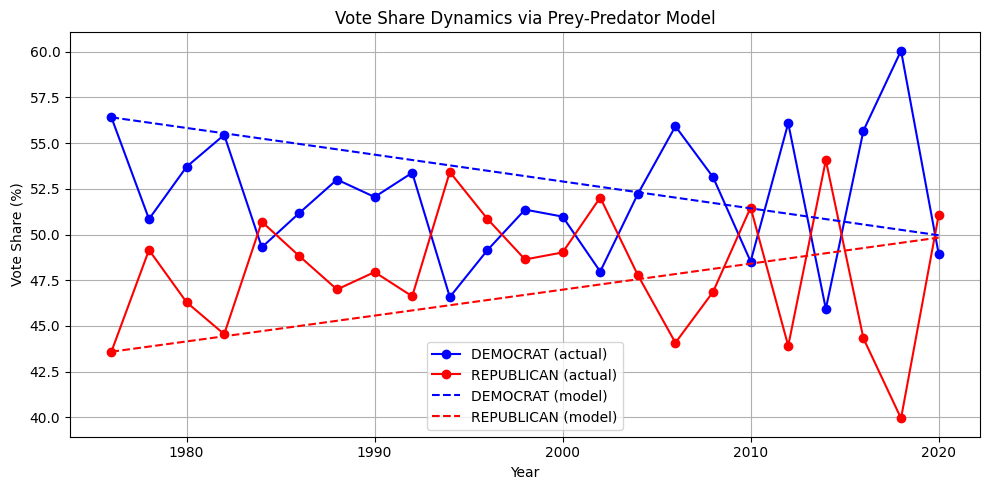

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(years, vote_A, 'bo-', label="DEMOCRAT (actual)")
plt.plot(years, vote_B, 'ro-', label="REPUBLICAN (actual)")
plt.plot(years, x_model, 'b--', label="DEMOCRAT (model)")
plt.plot(years, y_model, 'r--', label="REPUBLICAN (model)")
plt.xlabel("Year")
plt.ylabel("Vote Share (%)")
plt.title("Vote Share Dynamics via Prey-Predator Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()